In [4]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import tensorflow as tf
from imutils import paths
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator,img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [5]:
from matplotlib import image


data_path = "./dataset/"
imagePaths = list(paths.list_images(data_path))
imagePaths[:10]

['./dataset/with mask\\10.png',
 './dataset/with mask\\100.png',
 './dataset/with mask\\1004.png',
 './dataset/with mask\\1005.png',
 './dataset/with mask\\1006.png',
 './dataset/with mask\\1007.png',
 './dataset/with mask\\1008.png',
 './dataset/with mask\\1011.png',
 './dataset/with mask\\1012.png',
 './dataset/with mask\\1018.png']

In [6]:
images =[]
labels = []
for i in imagePaths[-2000:]+imagePaths[:2000]:
    # lấy label từ path ví dụ : ./dataset/with mask\\1012.png' => label = 'with mask'
    label = i.split(os.path.sep)[-2]
    labels.append(label)

    image = load_img(i,target_size=(224,224)) # resize size 
    image = img_to_array(image)  
    images.append(image)

# mã hóa dữ liệu thành định dạng numpy
images = np.array(images,dtype='float32')
labels  =np.array(labels)


In [7]:
images.shape

(4000, 224, 224, 3)

In [8]:
labels.shape

(4000,)

In [9]:
# mã hóa labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = tf.keras.utils.to_categorical(labels)

In [10]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [11]:
train_X, test_X, train_Y, test_Y = train_test_split(images,labels,test_size=0.5,stratify=labels,random_state=0)
val_X, test_X, val_Y, test_Y = train_test_split(test_X,test_Y,test_size=0.8,stratify=test_Y,random_state=0)

In [12]:
print(f"train_X :{train_X.shape} train_Y:{train_Y.shape}")
print(f"val_X :{val_X.shape} val_Y:{val_Y.shape}")
print(f"test_X :{test_X.shape} test_Y:{test_Y.shape}")

train_X :(2000, 224, 224, 3) train_Y:(2000, 2)
val_X :(400, 224, 224, 3) val_Y:(400, 2)
test_X :(1600, 224, 224, 3) test_Y:(1600, 2)


In [13]:
# tăng cường dữ liệu
aug = ImageDataGenerator(
    rotation_range = 20,
    zoom_range = 0.15,
    width_shift_range = 0.2,
    height_shift_range =0.2,
    shear_range = 0.15,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest'
)

In [14]:
# Sử dụng mô hình EfficientNet là mô hình cơ sở 
baseModel = tf.keras.applications.EfficientNetB0(include_top=False,weights='imagenet',input_tensor=tf.keras.layers.Input(shape=(224,224,3)))
baseModel.trainable =False

In [15]:
baseModel.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [16]:
from matplotlib import units


model = tf.keras.models.Sequential([
    baseModel,
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=2,activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        

In [18]:
learning_rate =0.001
epochs = 10
batch_size = 40
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=10000,
    decay_rate=learning_rate/epochs
)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy',
            optimizer=opt,
            metrics=['acc'])
history = model.fit(
    aug.flow(train_X,train_Y,batch_size=batch_size),
    steps_per_epoch = len(train_X)//batch_size,
    validation_data = (val_X,val_Y),
    validation_steps= len(val_X)//batch_size,
    epochs=epochs
)

Epoch 1/10
50/50 [==============================] - 164s 3s/step - loss: 0.1556 - acc: 0.9540 - val_loss: 0.1271 - val_acc: 0.9500
Epoch 2/10
50/50 [==============================] - 126s 3s/step - loss: 0.0688 - acc: 0.9825 - val_loss: 0.0551 - val_acc: 0.9825
Epoch 3/10
50/50 [==============================] - 162s 3s/step - loss: 0.0492 - acc: 0.9815 - val_loss: 0.0346 - val_acc: 0.9900
Epoch 4/10
50/50 [==============================] - 129s 3s/step - loss: 0.0423 - acc: 0.9855 - val_loss: 0.0790 - val_acc: 0.9625
Epoch 5/10
50/50 [==============================] - 103s 2s/step - loss: 0.0511 - acc: 0.9865 - val_loss: 0.0456 - val_acc: 0.9825
Epoch 6/10
50/50 [==============================] - 96s 2s/step - loss: 0.0356 - acc: 0.9895 - val_loss: 0.0246 - val_acc: 0.9875
Epoch 7/10
50/50 [==============================] - 97s 2s/step - loss: 0.0482 - acc: 0.9825 - val_loss: 0.0375 - val_acc: 0.9825
Epoch 8/10
50/50 [==============================] - 89s 2s/step - loss: 0.0339 - acc:

In [20]:
history.history

{'loss': [0.15560051798820496,
  0.06875515729188919,
  0.049207188189029694,
  0.042311087250709534,
  0.05112360417842865,
  0.03559761866927147,
  0.048173364251852036,
  0.03388810530304909,
  0.04658303037285805,
  0.023707639425992966],
 'acc': [0.9539999961853027,
  0.9825000166893005,
  0.9815000295639038,
  0.9854999780654907,
  0.9865000247955322,
  0.9894999861717224,
  0.9825000166893005,
  0.9900000095367432,
  0.9860000014305115,
  0.9925000071525574],
 'val_loss': [0.12714159488677979,
  0.05511036515235901,
  0.034569669514894485,
  0.07896814495325089,
  0.04562254995107651,
  0.02464064210653305,
  0.03750252351164818,
  0.034237056970596313,
  0.053798314183950424,
  0.0359613262116909],
 'val_acc': [0.949999988079071,
  0.9825000166893005,
  0.9900000095367432,
  0.9624999761581421,
  0.9825000166893005,
  0.987500011920929,
  0.9825000166893005,
  0.9900000095367432,
  0.9750000238418579,
  0.9850000143051147]}

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = np.arange(0,len(acc))


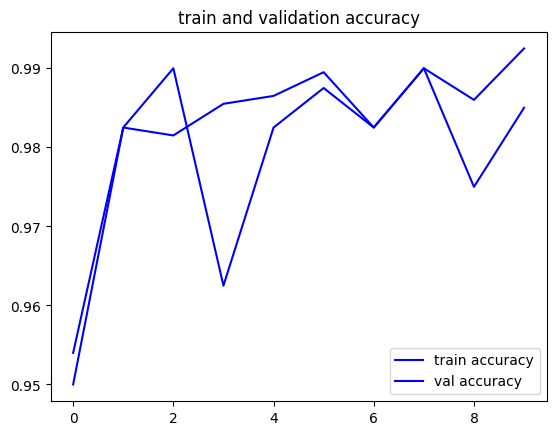

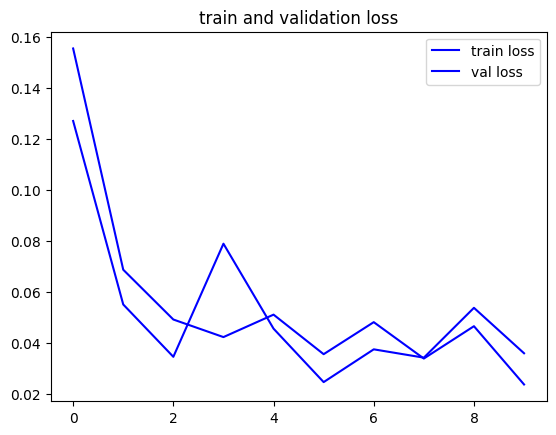

In [22]:
plt.figure()
plt.plot(epoch,acc,'b',label="train accuracy")
plt.plot(epoch,val_acc,'b',label="val accuracy")
plt.title("train and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epoch,loss,'b',label="train loss")
plt.plot(epoch,val_loss,'b',label="val loss")
plt.title("train and validation loss")
plt.legend()

In [23]:
test_X[0].shape

(224, 224, 3)

In [24]:
name_classes = ['mask','no mask']

In [25]:
result = model.predict(tf.expand_dims(test_X[0],0))


1/1 [==============================] - 2s 2s/step


In [26]:
name_class = name_classes[result.argmax()]
name_class

'mask'

Text(0.5, 1.0, 'mask')

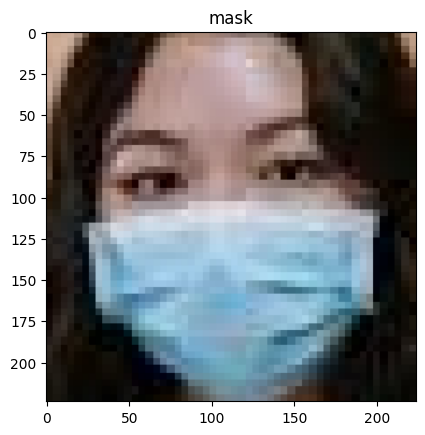

In [27]:
plt.imshow((test_X[0]/255.))
plt.title(name_class)

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 128)               1474688   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                        